In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/second_take

/content/drive/MyDrive/Colab Notebooks/second_take


In [4]:
#===========================================================
# Config
#===========================================================

import yaml

with open('./src/config.yaml') as file:
    config = yaml.safe_load(file.read())

assert config['task'] == 'regression'

df_path_dict = {'train': config['input_dir_root']+'train.csv',
                'test': config['input_dir_root']+'test.csv',
                'sample_submission': config['input_dir_root']+'sample_submission.csv',
                'folds': config['input_dir']+'folds.csv',}

config['feat_excluded'] = [
    config['id'], config['target'],
    'art_series_id',
    'title',
    'description',
    'long_title',
    'more_title',
    'acquisition_date',
    'dating_presenting_date',
    'sub_title'
    ]

In [5]:
config['model']

'lgbm'

In [6]:

#===========================================================
# Metrics
#===========================================================

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
    
def get_score(y_true, y_pred):
    score = rmsle(y_true, y_pred)
    return score

def custom_eval(preds, data):
    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)
    metric = np.mean(y_true == y_pred)
    return 'accuracy', metric, True

#===========================================================
# Model params
#===========================================================

def get_params(n_fold, config):
    if config['model'] == "lgbm":
        # parameters document
        # https://lightgbm.readthedocs.io/en/latest/Parameters.html
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'learning_rate': 0.05,
            'max_depth': -1,
            'subsample': 0.6,
            'colsample_bytree': 0.4,
            'num_leaves': 32,
            'min_data_in_leaf': 20,
            #'reg_alpha': 0.1,
            #'reg_lambda': 0.1,
            'seed': int(2 ** n_fold)+config['seed'],
            'num_boost_round': 10000,
            'early_stopping_rounds': 200,
            'verbose_eval': 100
            }
    elif config['model'] == "xgb":
        # parameters document
        # https://xgboost.readthedocs.io/en/latest/parameter.html
        params = {
            'objective':'reg:squarederror',
            'eval_metric':'rmse',
            'learning_rate': 0.05,
            'max_depth': 10,
            'subsample': 0.6,
            'colsample_bytree': 0.4,  
            #'min_child_weight':3,
            #'gamma':0.25,
            'seed': int(2 ** n_fold)+config['seed'],
            'num_boost_round': 5000,
            'early_stopping_rounds': 50,
            'verbose_eval': 10
            }
    elif config['model'] == "catb":
        # parameters document
        # https://catboost.ai/docs/concepts/loss-functions.html
        # https://catboost.ai/docs/concepts/python-reference_parameters-list.html
        params = {
            "loss_function": "RMSE",
            "eval_metric": "RMSE",
            "task_type": "CPU",
            'learning_rate': 0.05,
            "iterations": 6000,
            "early_stopping_rounds": 200,
            "verbose": 100,
            "random_seed": int(2 ** n_fold)+config['seed']
            }
    else:
        raise(ValueError("model name is not defined"))
    
    return params


In [7]:
# !pip install catboost
# from catboost import CatBoostClassifier, CatBoostRegressor

In [8]:
#===========================================================
# Library
#===========================================================
import gc
import json
import os
import random
import sys
import time
import warnings
from collections import Counter, defaultdict
from contextlib import contextmanager
from functools import partial
from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

warnings.filterwarnings('ignore')

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import torch
import xgboost as xgb
# from catboost import CatBoostClassifier, CatBoostRegressor
from gensim.models.word2vec import Word2Vec
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import (GroupKFold, GroupShuffleSplit, KFold,
                                     StratifiedKFold)
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm



In [9]:
#===========================================================
# Utils
#===========================================================

def seed_everything(seed=1996):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


@contextmanager
def timer(name):
    t0 = time.time()
    logger.info(f'[{name}] start')
    yield
    logger.info(f'[{name}] done in {time.time() - t0:.0f} s')
    logger.info('')


def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger(config['output_dir']+config['fname_log_cv'])

def load_df(path, df_name, config):
    if path.split('.')[-1]=='csv':
        if config['debug']:
            df = pd.read_csv(path, nrows=1000)
        else:
            df = pd.read_csv(path)
    elif path.split('.')[-1]=='pkl':
        df = pd.read_pickle(path)
    logger.info(f"{df_name} shape / {df.shape} ")
    return df

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        logger.info('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def drop_null_columns(train_df, test_df, columns, th=0.99, verbose=False):
    logger.info("original columns: {}".format(len(columns)))
    df = train_df.append(test_df, sort=False)
    drop_col = []
    use_col = []
    for col in columns:
        null_num = df[col].isnull().sum()
        try:
            unique_num = df[col].value_counts()[0]
        except:
            unique_num = 0
        null_rate = (null_num + unique_num) / len(df)
        if null_rate >= th:
            drop_col.append(col)
            if verbose:
                print(col, null_rate)
        else:
            use_col.append(col)
    
    logger.info("{} columns is null.".format(len(drop_col)))
    return use_col


In [10]:
#===========================================================
# Visualize
#===========================================================
def get_importance(feature_importance_df_, top_n=50):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:top_n].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)][["feature", "importance"]].reset_index(drop=True)
    best_features = best_features.sort_values(by="importance", ascending=False)

    return best_features, list(cols)

def display_importances(feature_importance_df_, img_fname):
    best_features, _ = get_importance(feature_importance_df_)

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig(img_fname)



In [11]:
#===========================================================
# Model
#===========================================================
def modeling_lightgbm(train_x, train_y, valid_x, valid_y, test_x, config):

    params = config['params']

    # set data structure
    lgb_train = lgb.Dataset(train_x,
                            label=train_y,
                            free_raw_data=False)
    lgb_test = lgb.Dataset(valid_x,
                            label=valid_y,
                            free_raw_data=False)

    model = lgb.train(
                params,
                lgb_train,
                valid_sets=[lgb_train, lgb_test],
                valid_names=['train', 'test'],
                num_boost_round=params['num_boost_round'],
                early_stopping_rounds= params['early_stopping_rounds'],
                verbose_eval=params['verbose_eval'],
                feval=config['feval'],
                )

    valid_pred = model.predict(valid_x, num_iteration=model.best_iteration)
    sub_pred = model.predict(test_x, num_iteration=model.best_iteration)
    
    return valid_pred, sub_pred, model.feature_importance(importance_type='gain', iteration=model.best_iteration)

def modeling_xgboost(train_x, train_y, valid_x, valid_y, test_x, config):

    params = config['params']

    xgb_train = xgb.DMatrix(train_x, train_y)
    xgb_test = xgb.DMatrix(valid_x, valid_y)
    
    model = xgb.train(
        params, 
        xgb_train,
        evals=[(xgb_train, 'train'), (xgb_test, 'val')],
        num_boost_round=params['num_boost_round'],
        early_stopping_rounds=params['early_stopping_rounds'],
        verbose_eval=params['verbose_eval'])
    
    valid_pred = model.predict(xgb.DMatrix(valid_x), ntree_limit=model.best_ntree_limit)
    sub_pred = model.predict(xgb.DMatrix(test_x), ntree_limit=model.best_ntree_limit)

    return valid_pred, sub_pred

def modeling_catboost(train_x, train_y, valid_x, valid_y, test_x, config):
    
    params = config['params']

    model = CatBoostRegressor(**params)
    
    model.fit(
        train_x,
        train_y,
        eval_set=(valid_x, valid_y),
        use_best_model=True,
        early_stopping_rounds=params["early_stopping_rounds"],
        verbose=params["verbose"])
    
    valid_pred = model.predict(valid_x)
    sub_pred = model.predict(test_x)
    
    return valid_pred, sub_pred, model.get_feature_importance()
    
def get_model_predict(train_x, train_y, valid_x, valid_y, test_x,  config):

    if config['model'] == "lgbm":
        return modeling_lightgbm(train_x, train_y, valid_x, valid_y, test_x, config)
    
    elif config['model'] == "xgb":
        return modeling_xgboost(train_x, train_y, valid_x, valid_y, test_x, config)

    elif config['model'] == "catb":
        return modeling_catboost(train_x, train_y, valid_x, valid_y, test_x, config)
    
    else:
        raise(ValueError("model name is not defined"))



In [12]:
#===========================================================
# Train and Predict
#===========================================================

def kfold_modeling(train_df, test_df, config):
    # Create arrays and dataframes to store results
    seed_everything(config['seed'])
    folds = load_df(path=df_path_dict['folds'], df_name='folds', config=config)

    oof_preds = np.zeros((train_df.shape[0]))
    sub_preds = np.zeros((test_df.shape[0]))

    if config['model'] in ["lgbm", 'catb']:
        feature_importance_df = pd.DataFrame()

    # k-fold
    scores = []
    for n_fold in range(config['num_folds']):

        logger.info('Starting fold {}'.format(n_fold)) 

        train_idx, valid_idx = folds[folds['folds'] != n_fold].index,  folds[folds['folds'] == n_fold].index
        train_fold = pd.read_pickle(config['input_dir']+f'train_fold{n_fold}.pkl')
        valid_fold = pd.read_pickle(config['input_dir']+f'valid_fold{n_fold}.pkl')
        test_fold = pd.read_pickle(config['input_dir']+f'test_fold{n_fold}.pkl')

        feats = [f for f in test_fold.columns if f not in config['feat_excluded']]
        #feats = drop_null_columns(train_df, test_df, feats)

        config['feats'] = feats
    
        train_x, train_y = train_fold[config['feats']], train_fold[config['target']]
        valid_x, valid_y = valid_fold[config['feats']], valid_fold[config['target']]
        test_x = test_fold[config['feats']]
        
        config['params'] = get_params(n_fold, config)

        if config['custom_eval']:
            config['feval'] = custom_eval
            config['params']['metric'] = "custom"
        logger.info('params: {}'.format(config['params']))
        
        if config['do_log_scale']:
            train_y = np.log1p(train_y)
            valid_y = np.log1p(valid_y)
        
        if n_fold == 0:
            logger.info(config['feats'])
        logger.info('len(trn_idx) : {} len(val_idx) : {} len(feature) : {}'.format(len(train_idx), len(valid_idx), len(config['feats'])))

        if config['model'] in ["lgbm", 'catb']:
            valid_pred, sub_pred, feature_importance = get_model_predict(train_x, train_y, valid_x, valid_y, test_x, config)
        else:
            valid_pred, sub_pred = get_model_predict(train_x, train_y, valid_x, valid_y, test_x, config)
        
        if config['do_log_scale']:
            valid_pred = np.exp(valid_pred) - 1
            sub_pred = np.exp(sub_pred) - 1
            valid_y = np.exp(valid_y) - 1
        
        if config['cat_negative_value']:
            valid_pred = np.where(valid_pred < 0, 0.0, valid_pred)
            sub_pred = np.where(sub_pred < 0, 0.0, sub_pred)

        oof_preds[valid_idx] = valid_pred
        sub_preds += (sub_pred / config['num_folds'])

        if config['model'] in ["lgbm", 'catb']:
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = test_x.columns
            fold_importance_df["importance"] = np.log1p(feature_importance)
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        logger.info("{} fold {} score: {:<8.5f}".format(config['model'], n_fold, get_score(valid_y, oof_preds[valid_idx])))
        scores.append(get_score(valid_y, valid_pred))
        logger.info('')

        del train_x, train_y, valid_x, valid_y
        gc.collect()
    
    logger.info("{} CV(all) score: {:<8.5f}".format(config['model'], get_score(train_df[config['target']], oof_preds)))
    logger.info("{} CV(ave) score: {:<8.5f}±{:<8.5f}".format(config['model'], np.mean(scores), np.std(scores)))

    if config['model'] in ["lgbm", 'catb']:
        # display importances
        display_importances(feature_importance_df, config['output_dir']+config['fname_importance'])
        feature_importance_df.to_csv(config['output_dir']+'feature_importance.csv', index=False)

    return oof_preds, sub_preds


Basic Config
   debug: False
   task: regression
   input_dir_root: ./input/
   input_dir_root_jn: ../input/
   input_dir: ./src/input/
   input_dir_jn: ../src/input/
   output_dir: ./src/output/
   output_dir_jn: ../src/output/
   output_dir_fold: ../src/input/
   output_dir_pp: ../src/input/
   output_dir_cv: ./src/output/
   fname_submission: submission.csv
   fname_log_fold: log_fold
   fname_log_pp: log_pp
   fname_log_cv: log_cv
   fname_importance: feature_importance.png
   fname_cm: cm.png
   cm_class: ['0', '1']
   id: object_id
   target: likes
   seed: 1996
   num_folds: 5
   split_type: group
   split_group: art_series_id
   split_target: likes
   shuffle: False
   model: lgbm
   num_class: 1
   num_seed: 1
   do_log_scale: True
   cat_negative_value: True
   do_weight: False
   custom_eval: None
   feval: None
   optim_th: False
   feat_excluded: ['object_id', 'likes', 'art_series_id', 'title', 'description', 'long_title', 'more_title', 'acquisition_date', 'dating_presenti

Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.7999	test's rmse: 0.998417
[200]	train's rmse: 0.632149	test's rmse: 0.979992
[300]	train's rmse: 0.522779	test's rmse: 0.974688
[400]	train's rmse: 0.440222	test's rmse: 0.968789
[500]	train's rmse: 0.375104	test's rmse: 0.966689
[600]	train's rmse: 0.321973	test's rmse: 0.964862
[700]	train's rmse: 0.278273	test's rmse: 0.964555
[800]	train's rmse: 0.240813	test's rmse: 0.964274
[900]	train's rmse: 0.210741	test's rmse: 0.96405
[1000]	train's rmse: 0.18357	test's rmse: 0.964247
Early stopping, best iteration is:
[893]	train's rmse: 0.212717	test's rmse: 0.963909


lgbm fold 0 score: 0.96372 

Starting fold 1
params: {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': -1, 'subsample': 0.6, 'colsample_bytree': 0.4, 'num_leaves': 32, 'min_data_in_leaf': 20, 'seed': 1998, 'num_boost_round': 10000, 'early_stopping_rounds': 200, 'verbose_eval': 100}
len(trn_idx) : 9621 len(val_idx) : 2405 len(feature) : 1160


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.794338	test's rmse: 1.03412
[200]	train's rmse: 0.629147	test's rmse: 1.01887
[300]	train's rmse: 0.521687	test's rmse: 1.01445
[400]	train's rmse: 0.441585	test's rmse: 1.01185
[500]	train's rmse: 0.377408	test's rmse: 1.01095
[600]	train's rmse: 0.326622	test's rmse: 1.01019
[700]	train's rmse: 0.284343	test's rmse: 1.00973
[800]	train's rmse: 0.248415	test's rmse: 1.00942
[900]	train's rmse: 0.217507	test's rmse: 1.00883
[1000]	train's rmse: 0.191223	test's rmse: 1.00883
Early stopping, best iteration is:
[869]	train's rmse: 0.226329	test's rmse: 1.00844


lgbm fold 1 score: 1.00808 

Starting fold 2
params: {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': -1, 'subsample': 0.6, 'colsample_bytree': 0.4, 'num_leaves': 32, 'min_data_in_leaf': 20, 'seed': 2000, 'num_boost_round': 10000, 'early_stopping_rounds': 200, 'verbose_eval': 100}
len(trn_idx) : 9621 len(val_idx) : 2405 len(feature) : 1160


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.794519	test's rmse: 1.02987
[200]	train's rmse: 0.629494	test's rmse: 1.01568
[300]	train's rmse: 0.522198	test's rmse: 1.01004
[400]	train's rmse: 0.441258	test's rmse: 1.00823
[500]	train's rmse: 0.376894	test's rmse: 1.00774
[600]	train's rmse: 0.321903	test's rmse: 1.00632
[700]	train's rmse: 0.279116	test's rmse: 1.00599
[800]	train's rmse: 0.241702	test's rmse: 1.00544
[900]	train's rmse: 0.2105	test's rmse: 1.00571
[1000]	train's rmse: 0.184367	test's rmse: 1.00645
Early stopping, best iteration is:
[836]	train's rmse: 0.230123	test's rmse: 1.00522


lgbm fold 2 score: 1.00495 

Starting fold 3
params: {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': -1, 'subsample': 0.6, 'colsample_bytree': 0.4, 'num_leaves': 32, 'min_data_in_leaf': 20, 'seed': 2004, 'num_boost_round': 10000, 'early_stopping_rounds': 200, 'verbose_eval': 100}
len(trn_idx) : 9621 len(val_idx) : 2405 len(feature) : 1160


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.797307	test's rmse: 1.02971
[200]	train's rmse: 0.631898	test's rmse: 1.01337
[300]	train's rmse: 0.525095	test's rmse: 1.00964
[400]	train's rmse: 0.444557	test's rmse: 1.00672
[500]	train's rmse: 0.378956	test's rmse: 1.00535
[600]	train's rmse: 0.324605	test's rmse: 1.00505
[700]	train's rmse: 0.279997	test's rmse: 1.00489
[800]	train's rmse: 0.244062	test's rmse: 1.00577
Early stopping, best iteration is:
[686]	train's rmse: 0.285963	test's rmse: 1.00453


lgbm fold 3 score: 1.00442 

Starting fold 4
params: {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': -1, 'subsample': 0.6, 'colsample_bytree': 0.4, 'num_leaves': 32, 'min_data_in_leaf': 20, 'seed': 2012, 'num_boost_round': 10000, 'early_stopping_rounds': 200, 'verbose_eval': 100}
len(trn_idx) : 9621 len(val_idx) : 2405 len(feature) : 1160


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.784466	test's rmse: 1.08345
[200]	train's rmse: 0.622578	test's rmse: 1.06926
[300]	train's rmse: 0.517808	test's rmse: 1.06575
[400]	train's rmse: 0.436609	test's rmse: 1.06318
[500]	train's rmse: 0.37213	test's rmse: 1.06136
[600]	train's rmse: 0.318409	test's rmse: 1.06089
[700]	train's rmse: 0.274753	test's rmse: 1.06066
[800]	train's rmse: 0.239007	test's rmse: 1.06142
[900]	train's rmse: 0.20916	test's rmse: 1.06191
Early stopping, best iteration is:
[712]	train's rmse: 0.270146	test's rmse: 1.06054


lgbm fold 4 score: 1.06044 

lgbm CV(all) score: 1.00879 
lgbm CV(ave) score: 1.00832 ±0.03077 
[Run Models] done in 490 s

[submission] start
[submission] done in 0 s



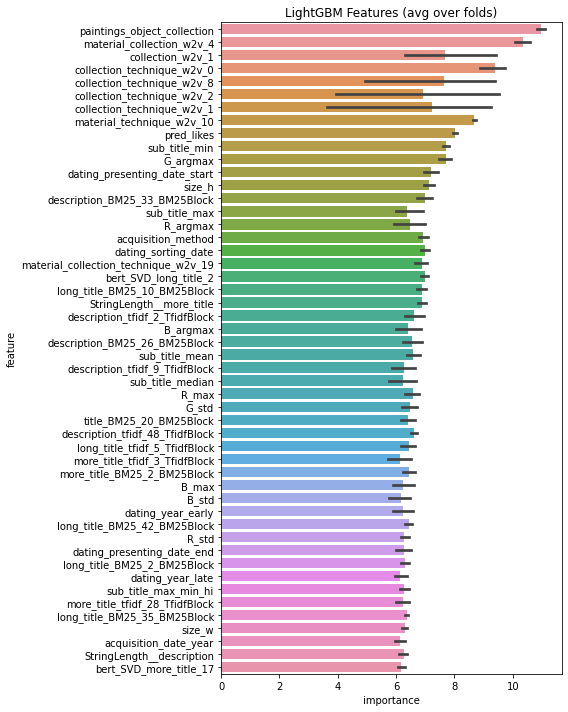

In [13]:
#===========================================================
# Main
#===========================================================
def main():
    logger.info('Basic Config')
    for k, v in config.items():
        logger.info('   {}: {}'.format(k, v))
    logger.info('')

    with timer('Data Loading'):
        train = load_df(path=df_path_dict['train'], df_name='train', config=config)
        #train = reduce_mem_usage(train)
        test = load_df(path=df_path_dict['test'], df_name='test', config=config)
        #test = reduce_mem_usage(test)
        sample_submission = load_df(path=df_path_dict['sample_submission'], df_name='sample_submission', config=config)
    

    with timer('Run Models'):
        if config['num_seed'] > 1:
            oof_preds = []
            sub_preds = []
            for idx in range(config['num_seed']):
                config['seed'] += idx
                oof_pred, sub_pred = kfold_modeling(train, test, config)
                oof_preds.append(oof_pred,)
                sub_preds.append(sub_pred)
            
            oof_pred = np.mean(oof_preds, axis=0)
            sub_pred = np.mean(sub_preds, axis=0)

            logger.info("{} CV(RSA) score: {:<8.5f}".format(config['model'], get_score(train[config['target']], sub_pred)))
        else:
            oof_pred, sub_pred = kfold_modeling(train, test, config)

        train['pred'] = oof_pred
        test['pred'] = sub_pred
        train[[config['id'], 'pred']].to_pickle(config['output_dir']+'oof.pkl')
        test[[config['id'], 'pred']].to_pickle(config['output_dir']+'sub.pkl')
    
    with timer("submission"):
        # submission
        sample_submission[config['target']] = sub_pred
        sample_submission.to_csv(config['output_dir']+config['fname_submission'], index=False)

if __name__ == "__main__":
    main()
